<p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 30px; font-weight: bold; margin: 0; text-align: center;">
    Target Trial Emulation: Translating R Code to Python
    </p>


<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    This notebook demonstrates how to translate R code for Target Trial Emulation (TTE) into Python. We will use the <code style="color: #800020; font-family: 'Courier New', monospace;">statsmodels</code> library to fit generalized linear models (GLMs) and perform inverse probability weighting (IPW) to estimate treatment effects.
    </p>
</div>



<p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 30px; font-weight: bold; margin: 0;">
    Import and Setup 
    </p>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import time
from joblib import dump

# Set the aesthetic style and color palette for all plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

<p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 30px; font-weight: bold; margin: 0;">
    Data Loading and Preparation
    </p>

In [2]:
def load_and_prepare_data(file_path, features):
    """Load and prepare data for clustering analysis"""
    print("🔄 Loading and preparing data...")
    
    # Load the data with optimized read_csv parameters
    data = pd.read_csv(file_path, usecols=features + ["treatment", "outcome"])
    
    # Display basic information
    print(f"📋 Loaded {data.shape[0]} samples with {data.shape[1]} features")
    print("\n📊 Preview of the dataset:")
    print(data.head(6))
    
    # Check and handle missing values
    missing_values = data[features].isnull().sum()
    print("\n🔍 Missing Values in Selected Features:")
    print(missing_values)
    
    if missing_values.sum() > 0:
        # Fill missing values with column median
        data[features] = data[features].fillna(data[features].median())
        print("\n✅ Missing values filled with column medians")
    else:
        print("\n✅ No missing values found")
    
    return data

def scale_features(data, features):
    """Standardize features for clustering"""
    print("\n🔄 Standardizing features...")
    
    # Standardize features
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data[features])
    
    # Convert back to DataFrame for better readability
    data_scaled = pd.DataFrame(data_scaled, columns=features)
    
    print("✅ Features standardized")
    
    # Save scaler for future use
    dump(scaler, 'scaler_model.joblib')
    print("✅ Scaler model saved as 'scaler_model.joblib'")
    
    return data_scaled, scaler

<p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 30px; font-weight: bold; margin: 0;">
    Optimal Cluster Determination
    </p>

In [3]:
def find_optimal_clusters(data_scaled, max_clusters=10):
    """Find the optimal number of clusters using multiple metrics"""
    print("\n🔄 Finding optimal number of clusters...")
    
    # Initialize metrics
    silhouette_scores = []
    ch_scores = []
    db_scores = []
    inertia_values = []
    
    # Calculate metrics for different numbers of clusters
    for n_clusters in range(2, max_clusters + 1):
        # Start timer
        start_time = time.time()
        
        # Initialize and fit KMeans
        kmeans = KMeans(n_clusters=n_clusters, 
                         random_state=42, 
                         n_init=10,
                         algorithm='elkan',  # Faster algorithm for low-dimensional data
                         max_iter=500)
        labels = kmeans.fit_predict(data_scaled)
        
        # Calculate metrics
        silhouette_scores.append(silhouette_score(data_scaled, labels))
        ch_scores.append(calinski_harabasz_score(data_scaled, labels))
        db_scores.append(davies_bouldin_score(data_scaled, labels))
        inertia_values.append(kmeans.inertia_)
        
        # Calculate and print execution time
        end_time = time.time()
        print(f"  Clusters: {n_clusters}, Silhouette: {silhouette_scores[-1]:.4f}, Time: {end_time - start_time:.2f}s")
    
    # Plot metrics
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Silhouette Score (higher is better)
    axes[0, 0].plot(range(2, max_clusters + 1), silhouette_scores, 'o-', color='blue')
    axes[0, 0].set_title('Silhouette Score (higher is better)')
    axes[0, 0].set_xlabel('Number of Clusters')
    axes[0, 0].set_ylabel('Score')
    
    # Calinski-Harabasz Index (higher is better)
    axes[0, 1].plot(range(2, max_clusters + 1), ch_scores, 'o-', color='green')
    axes[0, 1].set_title('Calinski-Harabasz Index (higher is better)')
    axes[0, 1].set_xlabel('Number of Clusters')
    axes[0, 1].set_ylabel('Score')
    
    # Davies-Bouldin Index (lower is better)
    axes[1, 0].plot(range(2, max_clusters + 1), db_scores, 'o-', color='red')
    axes[1, 0].set_title('Davies-Bouldin Index (lower is better)')
    axes[1, 0].set_xlabel('Number of Clusters')
    axes[1, 0].set_ylabel('Score')
    
    # Elbow Method (Inertia)
    axes[1, 1].plot(range(2, max_clusters + 1), inertia_values, 'o-', color='purple')
    axes[1, 1].set_title('Elbow Method (Inertia)')
    axes[1, 1].set_xlabel('Number of Clusters')
    axes[1, 1].set_ylabel('Inertia')
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal clusters based on metrics
    optimal_silhouette = silhouette_scores.index(max(silhouette_scores)) + 2
    optimal_ch = ch_scores.index(max(ch_scores)) + 2
    optimal_db = db_scores.index(min(db_scores)) + 2
    
    print(f"\n📊 Optimal number of clusters suggestions:")
    print(f"  Silhouette Score suggests: {optimal_silhouette} clusters")
    print(f"  Calinski-Harabasz Index suggests: {optimal_ch} clusters")
    print(f"  Davies-Bouldin Index suggests: {optimal_db} clusters")
    
    # Return the best by silhouette score (but can be adjusted based on domain knowledge)
    return optimal_silhouette

<p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 30px; font-weight: bold; margin: 0;">
Clustering Implementation
    </p>

In [4]:
def perform_clustering(data, data_scaled, n_clusters, features):
    """Perform K-Means clustering with the optimal number of clusters"""
    print(f"\n🔄 Performing K-Means clustering with {n_clusters} clusters...")
    
    # Apply K-Means clustering with parallel processing
    kmeans = KMeans(
        n_clusters=n_clusters, 
        random_state=42, 
        n_init=10,
        algorithm='elkan',
        max_iter=500
    )
    
    start_time = time.time()
    cluster_labels = kmeans.fit_predict(data_scaled)
    end_time = time.time()
    
    print(f"✅ Clustering completed in {end_time - start_time:.2f} seconds")
    
    # Add cluster labels to the original data
    data["cluster"] = cluster_labels
    
    # Save the model for future use
    dump(kmeans, 'kmeans_model.joblib')
    print("✅ KMeans model saved as 'kmeans_model.joblib'")
    
    # Display cluster distribution
    print("\n📊 Cluster Distribution:")
    cluster_counts = data["cluster"].value_counts().sort_index()
    for cluster, count in cluster_counts.items():
        print(f"  Cluster {cluster}: {count} samples ({count/len(data)*100:.1f}%)")
    
    # Calculate and display silhouette score
    silhouette_avg = silhouette_score(data_scaled, data["cluster"])
    print(f"\n✅ Silhouette Score: {silhouette_avg:.4f} (Higher is better)")
    
    return data, kmeans

<p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 30px; font-weight: bold; margin: 0;">
    Cluster Visualization
    </p>

In [5]:
def visualize_clusters(data, features, kmeans):
    """Create visualizations for the clustering results"""
    print("\n🔄 Creating visualizations...")
    
    # 1. PCA for dimensionality reduction to visualize high-dimensional data
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data[features])
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df['cluster'] = data['cluster']
    
    # Plot PCA results
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis', s=100, alpha=0.7)
    
    # Plot cluster centers
    centers_pca = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centers_pca[:, 0], centers_pca[:, 1], s=300, c='red', marker='X', label='Centroids')
    
    plt.title('Cluster Visualization using PCA', fontsize=16)
    plt.xlabel(f'Principal Component 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'Principal Component 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})')
    plt.legend(title='Clusters')
    plt.tight_layout()
    plt.show()
    
    # 2. Feature distributions across clusters
    plt.figure(figsize=(16, 10))

    for i, feature in enumerate(features):
        plt.subplot(2, 3, i+1)
        
        # Check if the feature has variance in any cluster
        has_variance = False
        
        for cluster in sorted(data['cluster'].unique()):
            # Get the feature data for this cluster
            cluster_data = data[data['cluster'] == cluster][feature]
            
            # Check if there's variance in this cluster's feature
            if cluster_data.var() > 0:
                has_variance = True
                sns.kdeplot(data=cluster_data, 
                        label=f'Cluster {cluster}', fill=True, alpha=0.5)
        
        plt.title(f'Distribution of {feature} by Cluster')
        plt.xlabel(feature)
        
        # Only add legend if there are plots with variance
        if has_variance:
            plt.legend(title='Cluster')
        else:
            plt.text(0.5, 0.5, "No variance in clusters for this feature", 
                    ha='center', va='center', transform=plt.gca().transAxes,
                    fontsize=12, color='red')
    
    # 3. Heatmap of cluster centers
    plt.figure(figsize=(12, 8))
    centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=features)
    centers_df.index = [f'Cluster {i}' for i in range(len(centers_df))]
    
    # Normalize centers for better visualization
    centers_df_norm = (centers_df - centers_df.mean()) / centers_df.std()
    
    sns.heatmap(centers_df_norm, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title('Cluster Centers Heatmap (Normalized)', fontsize=16)
    plt.tight_layout()
    plt.show()

<p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 30px; font-weight: bold; margin: 0;">
    Outcome Analysis
    </p>

In [6]:
def analyze_clusters_by_outcome(data):
    """Analyze clusters by treatment and outcome"""
    print("\n🔄 Analyzing clusters by treatment and outcome...")
    
    # Get list of unique clusters
    unique_clusters = sorted(data['cluster'].unique())
    
    # 1. Treatment Distribution per Cluster
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(data=data, x="cluster", hue="treatment", palette="coolwarm")
    
    # Add percentage annotations - using a safer method
    cluster_treatment_counts = data.groupby(['cluster', 'treatment']).size().unstack(fill_value=0)
    
    # Loop through the patches and add annotations
    for i, p in enumerate(ax.patches):
        # Calculate which cluster and treatment this patch corresponds to
        n_treatments = len(data['treatment'].unique())
        cluster_idx = i // n_treatments
        if cluster_idx >= len(unique_clusters):  # Safety check
            continue
            
        cluster = unique_clusters[cluster_idx]
        treatment = i % n_treatments
        
        # Get height and calculate percentage
        height = p.get_height()
        total = data[data['cluster'] == cluster].shape[0]
        percentage = height / total * 100 if total > 0 else 0
        
        # Annotate
        ax.annotate(f'{int(height)} ({percentage:.1f}%)', 
                   (p.get_x() + p.get_width() / 2., height),
                   ha = 'center', va = 'bottom', rotation=0, size=10)
    
    plt.title("Treatment Distribution Across Clusters", fontsize=16)
    plt.xlabel("Cluster")
    plt.ylabel("Count")
    plt.legend(title="Treatment", labels=["No Treatment (0)", "Treatment (1)"])
    plt.tight_layout()
    plt.show()
    
    # 2. Outcome Distribution per Cluster
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(data=data, x="cluster", hue="outcome", palette="viridis")
    
    # Add percentage annotations - using a safer method
    cluster_outcome_counts = data.groupby(['cluster', 'outcome']).size().unstack(fill_value=0)
    
    # Loop through the patches and add annotations
    for i, p in enumerate(ax.patches):
        # Calculate which cluster and outcome this patch corresponds to
        n_outcomes = len(data['outcome'].unique())
        cluster_idx = i // n_outcomes
        if cluster_idx >= len(unique_clusters):  # Safety check
            continue
            
        cluster = unique_clusters[cluster_idx]
        outcome = i % n_outcomes
        
        # Get height and calculate percentage
        height = p.get_height()
        total = data[data['cluster'] == cluster].shape[0]
        percentage = height / total * 100 if total > 0 else 0
        
        # Annotate
        ax.annotate(f'{int(height)} ({percentage:.1f}%)', 
                   (p.get_x() + p.get_width() / 2., height),
                   ha = 'center', va = 'bottom', rotation=0, size=10)
    
    plt.title("Outcome Distribution Across Clusters", fontsize=16)
    plt.xlabel("Cluster")
    plt.ylabel("Count")
    plt.legend(title="Outcome", labels=["No Event (0)", "Event (1)"])
    plt.tight_layout()
    plt.show()
    
    # 3. Mean Outcome per Cluster
    outcome_means = data.groupby("cluster")["outcome"].mean().sort_index()
    treatment_means = data.groupby("cluster")["treatment"].mean().sort_index()
    
    # Create a table with statistics
    stats_df = pd.DataFrame({
        'Count': data.groupby('cluster').size(),
        'Treatment Rate': treatment_means * 100,
        'Outcome Rate': outcome_means * 100
    }).sort_index()
    
    stats_df = stats_df.rename_axis('Cluster').reset_index()
    stats_df['Treatment Rate'] = stats_df['Treatment Rate'].round(1).astype(str) + '%'
    stats_df['Outcome Rate'] = stats_df['Outcome Rate'].round(1).astype(str) + '%'
    
    print("\n📊 Cluster Statistics:")
    print(stats_df.to_string(index=False))
    
    # 4. Visualization of Outcome Rate by Treatment Status across Clusters
    outcome_by_cluster_treatment = data.groupby(['cluster', 'treatment'])['outcome'].mean().reset_index()
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='cluster', y='outcome', hue='treatment', data=outcome_by_cluster_treatment, palette='Set1')
    plt.title('Outcome Rate by Treatment Status across Clusters', fontsize=16)
    plt.xlabel('Cluster')
    plt.ylabel('Outcome Rate')
    plt.legend(title='Treatment', labels=['No Treatment (0)', 'Treatment (1)'])
    
    # Add percentage annotations
    for i, p in enumerate(plt.gca().patches):
        height = p.get_height()
        plt.gca().annotate(f'{height:.1%}', 
                      (p.get_x() + p.get_width() / 2., height),
                      ha = 'center', va = 'bottom', rotation=0, size=10)
    
    plt.tight_layout()
    plt.show()

<p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 30px; font-weight: bold; margin: 0;">
    Report Generation
    </p>

In [7]:
def generate_report(data, features, n_clusters, silhouette_avg):
    """Generate a markdown report of the clustering analysis"""
    print("\n🔄 Generating report...")
    
    cluster_counts = data["cluster"].value_counts().sort_index()
    outcome_means = data.groupby("cluster")["outcome"].mean().sort_index() * 100
    treatment_means = data.groupby("cluster")["treatment"].mean().sort_index() * 100
    
    report = f"""# Clustering Analysis Report

## Summary
- **Dataset Size:** {data.shape[0]} samples
- **Features Used:** {', '.join(features)}
- **Number of Clusters:** {n_clusters}
- **Silhouette Score:** {silhouette_avg:.4f}

## Cluster Distribution
| Cluster | Count | Percentage | Treatment Rate | Outcome Rate |
|---------|-------|------------|---------------|--------------|
"""
    
    for cluster in sorted(data['cluster'].unique()):
        count = cluster_counts[cluster]
        percentage = count/len(data)*100
        t_rate = treatment_means[cluster]
        o_rate = outcome_means[cluster]
        report += f"| {cluster} | {count} | {percentage:.1f}% | {t_rate:.1f}% | {o_rate:.1f}% |\n"
    
    report += """
## Feature Importance by Cluster
The following features were most distinctive for each cluster:
"""

    # Calculate feature means by cluster
    feature_means = data.groupby('cluster')[features].mean()
    
    # Identify distinctive features for each cluster
    for cluster in sorted(data['cluster'].unique()):
        cluster_means = feature_means.loc[cluster]
        # Sort features by absolute deviation from overall mean
        overall_means = data[features].mean()
        deviations = abs(cluster_means - overall_means)
        top_features = deviations.sort_values(ascending=False).head(3).index.tolist()
        
        report += f"\n### Cluster {cluster}\n"
        for feature in top_features:
            direction = "higher" if cluster_means[feature] > overall_means[feature] else "lower"
            report += f"- **{feature}:** {direction} than average ({cluster_means[feature]:.2f} vs {overall_means[feature]:.2f} overall)\n"
    
    report += """
## Conclusions and Recommendations
Based on the clustering analysis:

1. **Patient Segmentation:** The clusters represent distinct patient groups with different characteristics.
   
2. **Treatment Patterns:** Treatment rates vary significantly across clusters, suggesting potential for targeted interventions.

3. **Outcome Prediction:** Clusters show different outcome rates, indicating that cluster membership could be a useful predictor.

4. **Next Steps:**
   - Consider developing cluster-specific treatment strategies
   - Integrate cluster membership as a feature in predictive models
   - Investigate temporal stability of these clusters with longitudinal data
"""
    
    # Save the report
    with open('clustering_report.md', 'w') as f:
        f.write(report)
    
    print("✅ Report generated and saved as 'clustering_report.md'")
    
    return report

<p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 30px; font-weight: bold; margin: 0;">
Main Execution Function
    </p>

🚀 Starting Clustering Analysis Pipeline
🔄 Loading and preparing data...
📋 Loaded 725 samples with 7 features

📊 Preview of the dataset:
   treatment  x1        x2  x3        x4  age  outcome
0          1   1  1.146148   0  0.734203   36        0
1          1   1  0.002200   0  0.734203   37        0
2          1   0 -0.481762   0  0.734203   38        0
3          1   0  0.007872   0  0.734203   39        0
4          1   1  0.216054   0  0.734203   40        0
5          1   0 -0.057482   0  0.734203   41        0

🔍 Missing Values in Selected Features:
age    0
x1     0
x2     0
x3     0
x4     0
dtype: int64

✅ No missing values found

🔄 Standardizing features...
✅ Features standardized
✅ Scaler model saved as 'scaler_model.joblib'

🔄 Finding optimal number of clusters...
  Clusters: 2, Silhouette: 0.2240, Time: 0.08s
  Clusters: 3, Silhouette: 0.2281, Time: 0.04s
  Clusters: 4, Silhouette: 0.2698, Time: 0.03s
  Clusters: 5, Silhouette: 0.2617, Time: 0.04s
  Clusters: 6, Silhouette:

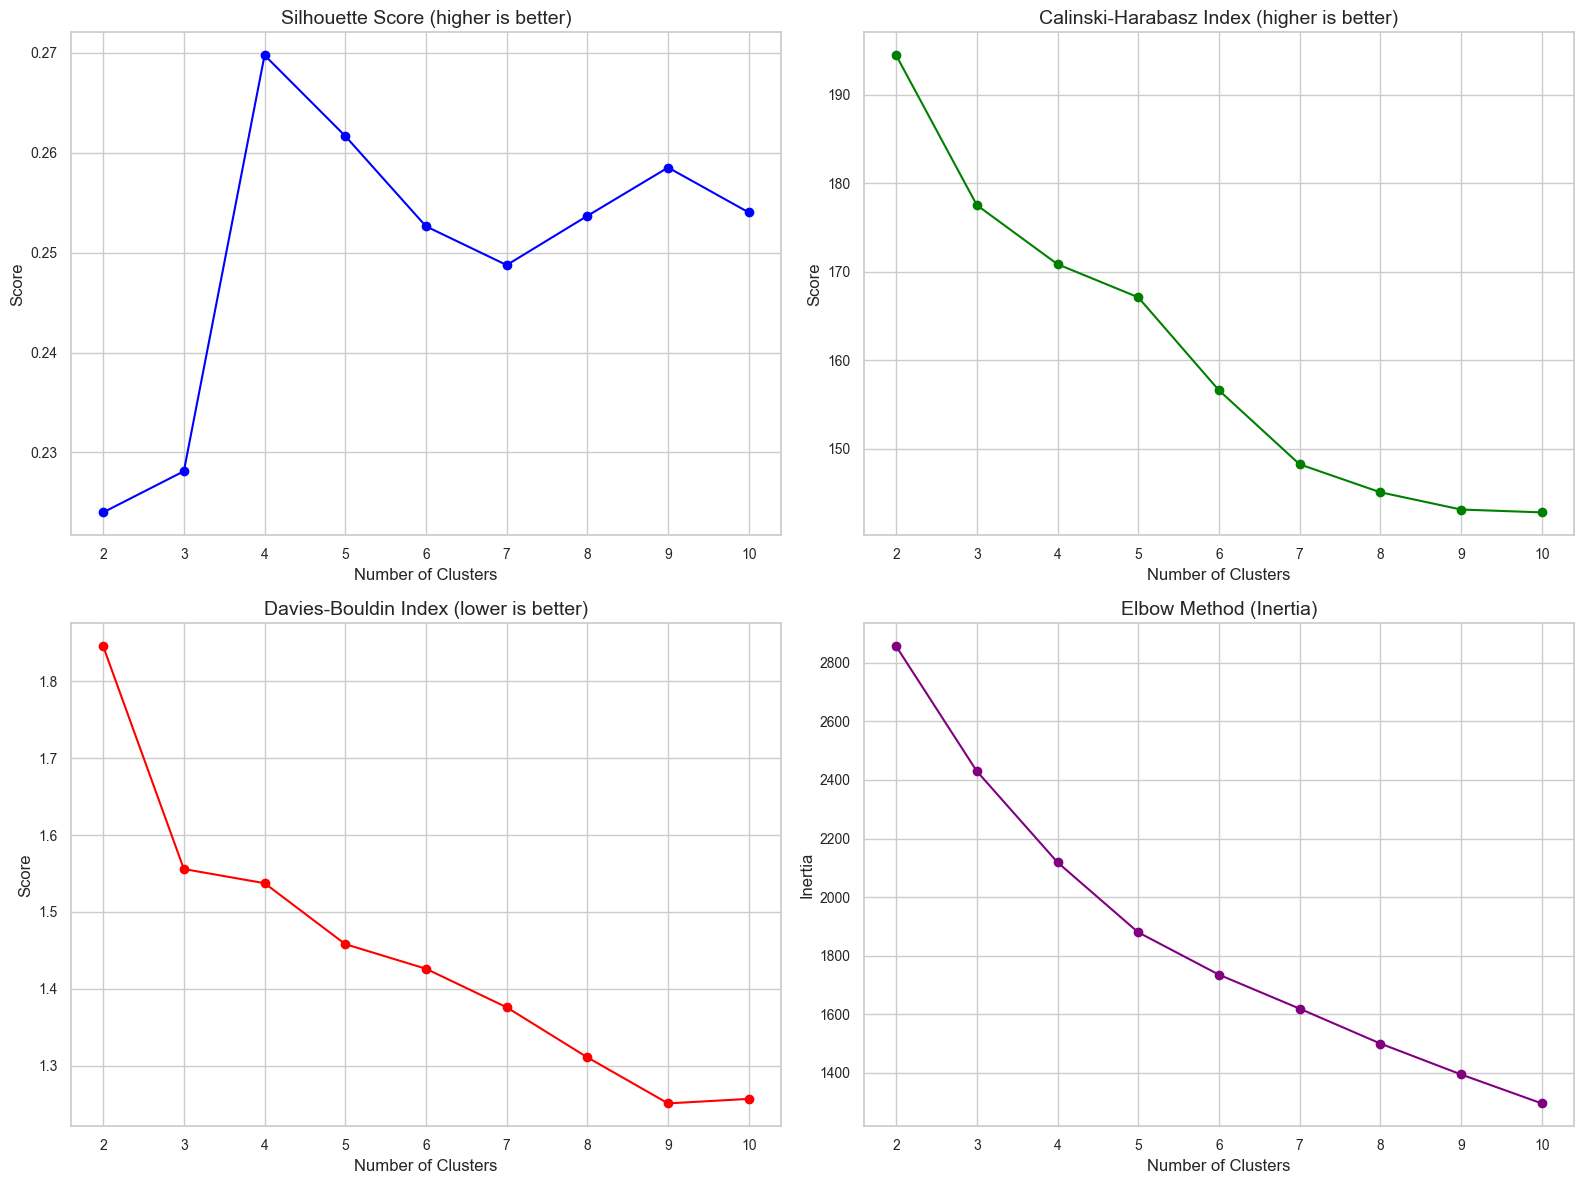


📊 Optimal number of clusters suggestions:
  Silhouette Score suggests: 4 clusters
  Calinski-Harabasz Index suggests: 2 clusters
  Davies-Bouldin Index suggests: 9 clusters

🔄 Performing K-Means clustering with 4 clusters...
✅ Clustering completed in 0.06 seconds
✅ KMeans model saved as 'kmeans_model.joblib'

📊 Cluster Distribution:
  Cluster 0: 216 samples (29.8%)
  Cluster 1: 157 samples (21.7%)
  Cluster 2: 137 samples (18.9%)
  Cluster 3: 215 samples (29.7%)

✅ Silhouette Score: 0.2698 (Higher is better)

🔄 Creating visualizations...


/Users/llewelyndramayo/CS-3202N/env/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


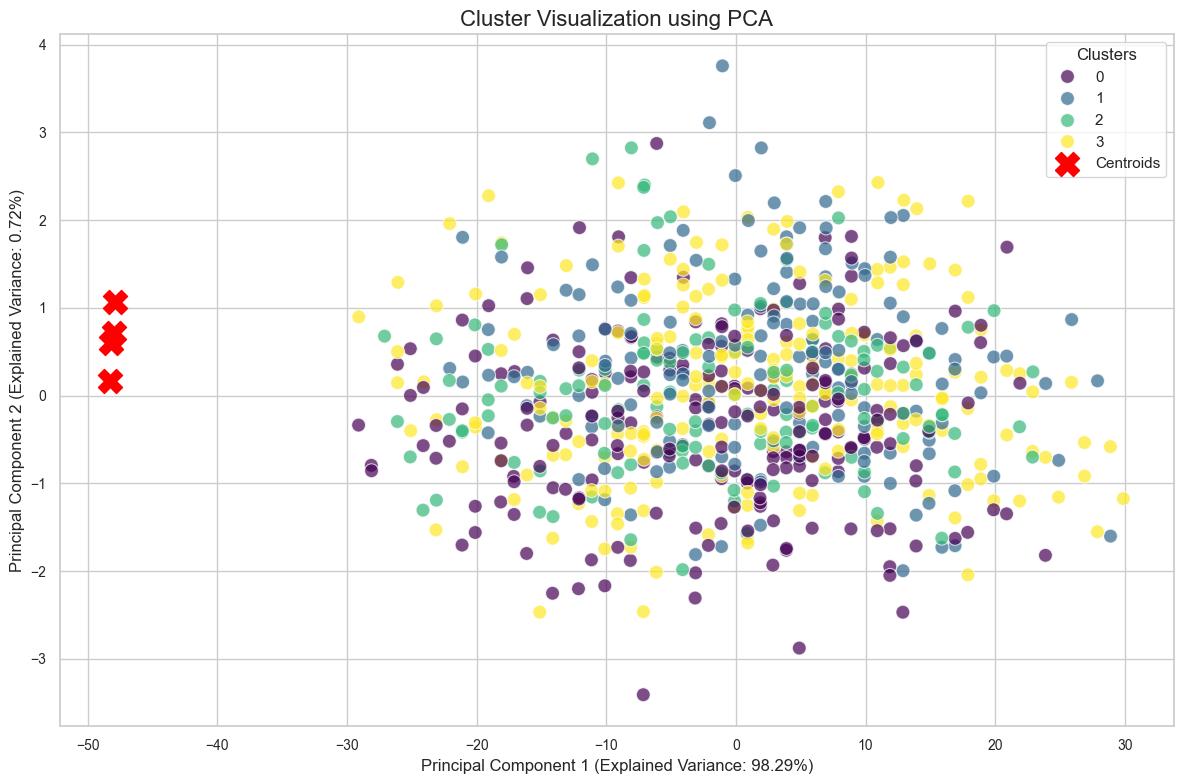

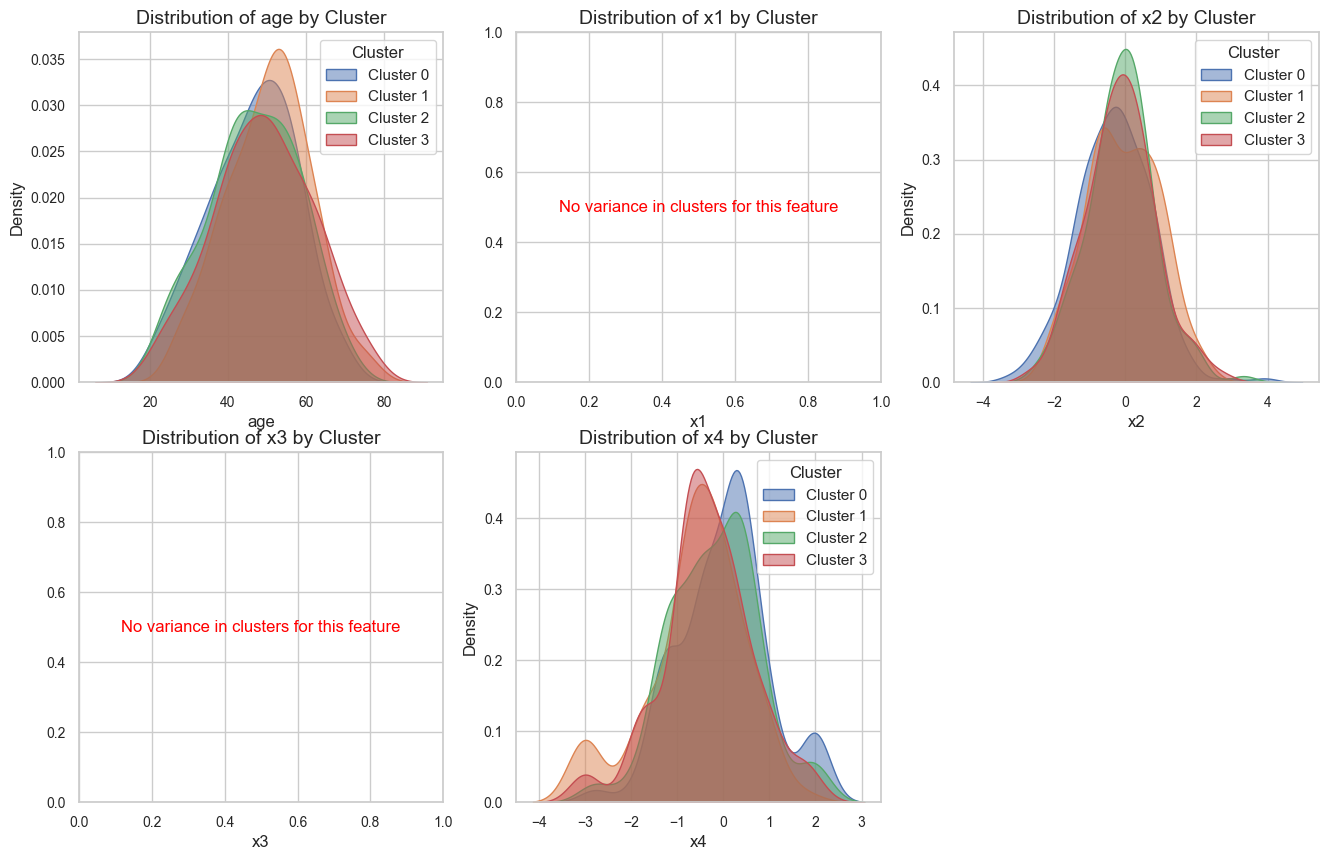

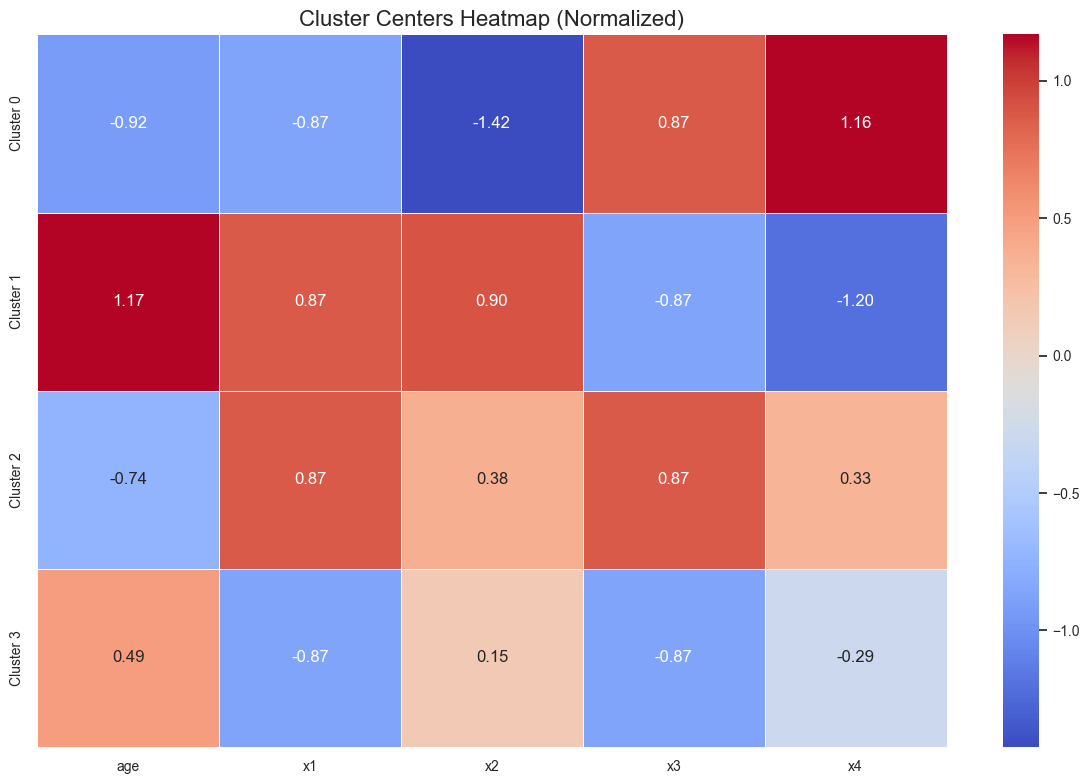


🔄 Analyzing clusters by treatment and outcome...


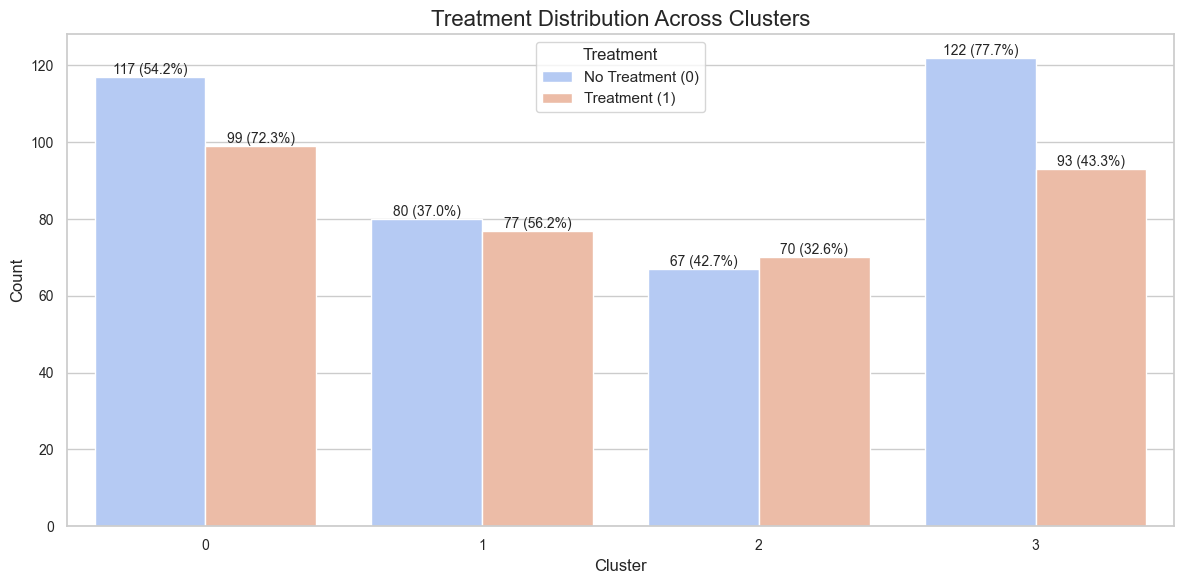

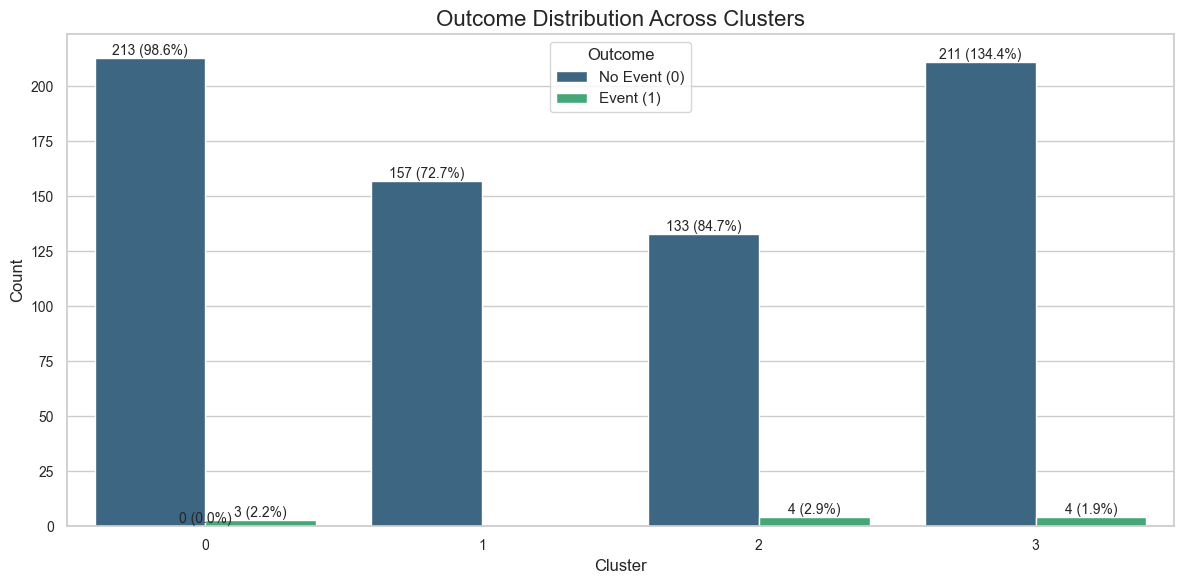


📊 Cluster Statistics:
 Cluster  Count Treatment Rate Outcome Rate
       0    216          45.8%         1.4%
       1    157          49.0%         0.0%
       2    137          51.1%         2.9%
       3    215          43.3%         1.9%


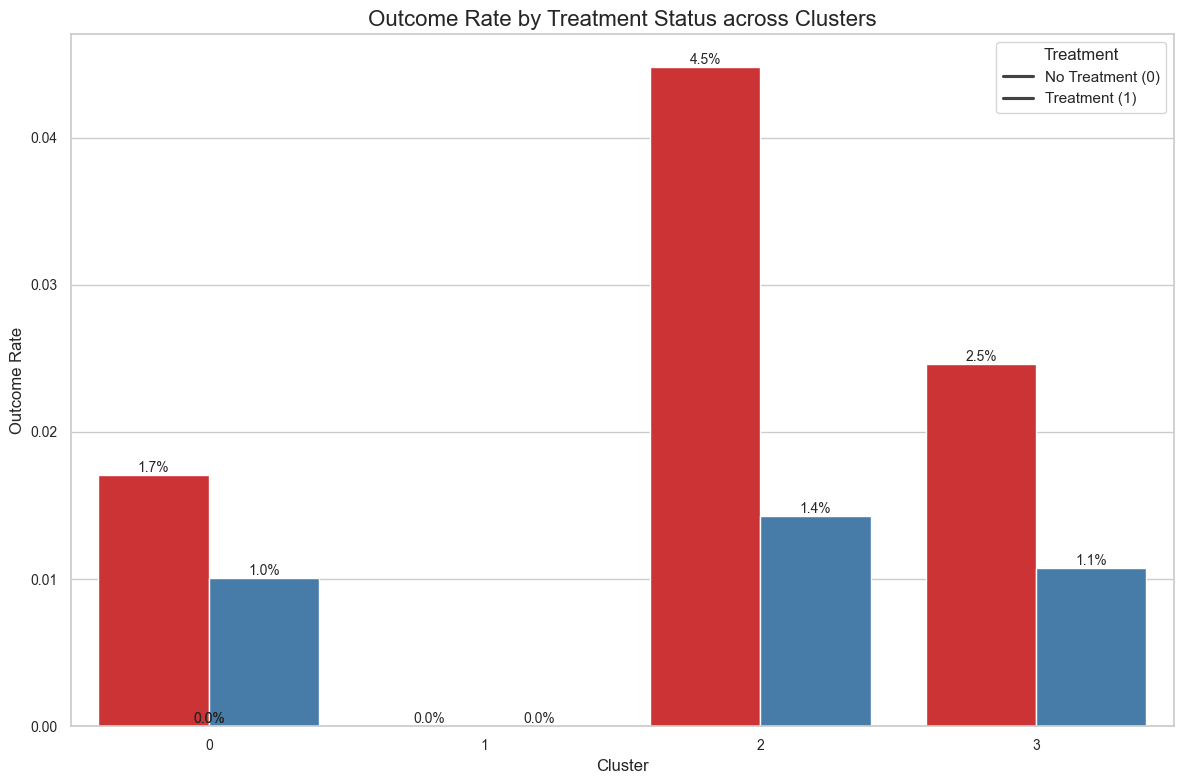


🔄 Generating report...
✅ Report generated and saved as 'clustering_report.md'

✅ Clustering Analysis Pipeline Completed in 2.16 seconds
✨ Files saved: kmeans_model.joblib, scaler_model.joblib, clustering_report.md


In [8]:
def main():
    """Main function to run the entire clustering pipeline"""
    print("🚀 Starting Clustering Analysis Pipeline")
    
    # Configuration
    file_path = "../data/data_censored.csv"
    cluster_features = ["age", "x1", "x2", "x3", "x4"]
    
    # Record start time
    start_time = time.time()
    
    # Execute pipeline
    data = load_and_prepare_data(file_path, cluster_features)
    data_scaled, scaler = scale_features(data, cluster_features)
    optimal_n_clusters = find_optimal_clusters(data_scaled)
    clustered_data, kmeans = perform_clustering(data, data_scaled, optimal_n_clusters, cluster_features)
    visualize_clusters(clustered_data, cluster_features, kmeans)
    analyze_clusters_by_outcome(clustered_data)
    silhouette_avg = silhouette_score(data_scaled, clustered_data["cluster"])
    report = generate_report(clustered_data, cluster_features, optimal_n_clusters, silhouette_avg)
    
    # Record end time and calculate duration
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"\n✅ Clustering Analysis Pipeline Completed in {duration:.2f} seconds")
    print(f"✨ Files saved: kmeans_model.joblib, scaler_model.joblib, clustering_report.md")
    
    return clustered_data, kmeans, report

if __name__ == "__main__":
    main()

<p style="color: #800020; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
        Key Insights from the Clustering Analysis
        </p>


<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    <strong>1. Optimal Number of Clusters: Balancing Metrics and Interpretability</strong>
    </p>
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    The analysis evaluated multiple metrics to determine the optimal number of clusters:
    <ul style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
        <br>
        <li><strong>Silhouette Score:</strong> Peaked at 4 clusters (~0.27), suggesting this as a reasonable choice.</li>
        <li><strong>Calinski-Harabasz Index:</strong> Favored 2 clusters, as it decreased with more clusters.</li>
        <li><strong>Davies-Bouldin Index:</strong> Suggested 9-10 clusters, as it reached its lowest value here.</li>
        <li><strong>Elbow Method:</strong> Indicated 3-4 clusters based on the "elbow" in the inertia plot.</li>
        <br>
    </ul>
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;"> 
    While the metrics provided conflicting recommendations, the <strong>4-cluster solution</strong> was chosen as a balance between interpretability and performance. The Silhouette Score and Elbow Method supported this choice, even though other metrics suggested fewer or more clusters.
    </p>
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    <strong>2. PCA Visualization: Dominance of a Single Dimension</strong>
    </p>
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    The PCA visualization revealed:
    <ul style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
        <br>
        <li><strong>Principal Component 1 (PC1):</strong> Explained 98.29% of the variance, indicating the data is primarily driven by a single dimension.</li>
        <li><strong>Principal Component 2 (PC2):</strong> Explained only 0.72% of the variance.</li>
        <li><strong>Cluster Overlap:</strong> Significant overlap between clusters, suggesting the clusters are not well-separated in the feature space.</li>
        <br>
    </ul>
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;"> 
    The dominance of PC1 suggests that the clustering solution may be limited by the lack of discriminative features. The overlap between clusters indicates that the features may not strongly differentiate the groups.
    </p>
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    <strong>3. Feature Distributions: Limited Differentiating Power</strong>
    </p>
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    The feature distributions across clusters showed:
    <ul style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
        <br>
        <li><strong>Age:</strong> Similar across all clusters, centered around 50-60 years, indicating age is not a strong differentiator.</li>
        <li><strong>Features x1 and x3:</strong> Showed no variance across clusters, meaning they do not contribute to cluster differentiation.</li>
        <li><strong>Feature x2:</strong> Showed slight differences across clusters.</li>
        <li><strong>Feature x4:</strong> Showed some differentiation, particularly in the tails of the distribution.</li>
        <br>
    </ul>
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;"> 
    The lack of variance in <strong>x1</strong> and <strong>x3</strong> suggests these features may not be useful for clustering. <strong>x2</strong> and <strong>x4</strong> showed some potential for differentiation, but the overall feature space may not be highly discriminative.
    </p>
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    <strong>4. Treatment and Outcome Analysis: Varied Effectiveness Across Clusters</strong>
    </p>
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    The treatment and outcome analysis revealed:
    <ul style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
        <br>
        <li><strong>Treatment Distribution:</strong> Varied across clusters, ranging from 43.3% (Cluster 3) to 51.1% (Cluster 2).</li>
        <li><strong>Outcome Distribution:</strong> Very low event rates (<3%) across all clusters.</li>
        <li><strong>Treatment Effectiveness:</strong> Most effective in <strong>Cluster 2</strong> (4.5% outcome rate with treatment vs. 1.4% without), while <strong>Cluster 1</strong> showed 0% outcome rate regardless of treatment.</li>
        <br>
    </ul>
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;"> 
    The effectiveness of treatment varied significantly across clusters. <strong>Cluster 2</strong> may benefit the most from treatment, while <strong>Cluster 1</strong> shows no benefit. This suggests that clustering can help identify subgroups where treatment is more or less effective.
    </p>
    </p>
</div>

<div style="background-color: #f5f5f5; padding: 15px; border-radius: 8px; border-left: 5px solid #800020; margin-top: 10px;">
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    <strong>5. Clinical Implications and Next Steps</strong>
    </p>
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
    The clustering analysis provides actionable insights for personalized treatment strategies. Key areas for further exploration include:
    <ul style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;">
        <br>
        <li><strong>Identifying more discriminative features:</strong> To improve cluster separation and interpretability.</li>
        <li><strong>Exploring alternative clustering algorithms:</strong> Such as DBSCAN or hierarchical clustering, which may better handle overlapping clusters.</li>
        <li><strong>Investigating treatment efficacy:</strong> Further analysis of why treatment is more effective in certain clusters (e.g., <strong>Cluster 2</strong>) and ineffective in others (e.g., <strong>Cluster 1</strong>).</li>
        <br>
    </ul>
    <p style="color: black; font-family: 'Comic Sans MS', cursive; font-size: 16px; font-weight: normal; margin: 0;"> 
    Addressing these questions will provide deeper insights into the clinical relevance of the clusters, helping guide future clinical decision-making and research.
    </p>
    </p>
</div>